<a href="https://colab.research.google.com/github/Naghiman/AppliedMachineLearning/blob/master/Multi-Class%20Logistic%20Regression%20and%20Gradient%20Descent/LR_GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# if sklearn version is not up to date then
# load_digits(as_frame=True) will fail 
# ! pip install scikit-learn==0.23.*

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import sklearn

from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from time import time
from tqdm.auto import tqdm

print(f'sklean version: {sklearn.__version__}')
%matplotlib notebook
%matplotlib inline
sns.set_theme()

sklean version: 0.23.2


# Datasets

## 1. Digits

In [ ]:
# LOAD AND PREPROCESS DIGITS DATASET

digits = load_digits(as_frame=True)
ddf = digits.frame
y_digits = ddf['target'].to_numpy()
ddf.drop("target", axis=1, inplace=True)
X_digits = ddf.to_numpy()

print(f'X_digits.shape: {X_digits.shape}')
print(f'y_digits.shape: {y_digits.shape}')

X_digits.shape: (1797, 64)
y_digits.shape: (1797,)


In [ ]:
# train, val, test split
X_trn_digits, X_tst_digits, y_trn_digits, y_tst_digits = sklearn.model_selection.train_test_split(X_digits, y_digits, test_size=1/5, random_state=0)

# preprocess scales
scaler_digits = sklearn.preprocessing.StandardScaler().fit(X_trn_digits)
X_trn_digits = scaler_digits.transform(X_trn_digits)
X_tst_digits = scaler_digits.transform(X_tst_digits)

## 2. Credit

In [ ]:
# LOAD AND PREPROCESS CREDIT-G DATASET
credit = fetch_openml(name='credit-g',as_frame=True)
cdf = credit.frame

# CONVERT CATEGORICAL FEATURES TO ONE-HOT ENCODING IN CREDIT-G
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(cdf[['checking_status','credit_history','purpose','savings_status','employment','personal_status','other_parties','property_magnitude','other_payment_plans','housing','job','own_telephone','foreign_worker']]).toarray())
cdf = cdf.join(enc_df)
cdf.drop(['checking_status','credit_history','purpose','savings_status','employment','personal_status','other_parties','property_magnitude','other_payment_plans','housing','job','own_telephone','foreign_worker'], axis=1, inplace=True)
class_dict = {"bad": 0, "good": 1}
y_credit = (cdf.replace({"class": class_dict})['class']).to_numpy()
cdf.drop("class", axis=1, inplace=True)
X_credit = cdf.to_numpy()

print(f'X_credit.shape: {X_credit.shape}')
print(f'y_credit.shape: {y_credit.shape}')

X_credit.shape: (1000, 61)
y_credit.shape: (1000,)


In [ ]:
# train, val, test split
X_trn_credit, X_tst_credit, y_trn_credit, y_tst_credit = sklearn.model_selection.train_test_split(X_credit, y_credit, test_size=1/5, random_state=0)

# preprocess scales
scaler_credit = sklearn.preprocessing.StandardScaler().fit(X_trn_credit)
X_trn_credit = scaler_credit.transform(X_trn_credit)
X_tst_credit = scaler_credit.transform(X_tst_credit)

# Softmax Regression

## Multi-class logistic regression model

In [ ]:
class SoftmaxRegression:
    def __init__(self, add_bias=True, reg=0):
        self.add_bias = add_bias
        self.reg = reg

    def fit(self, x_trn, y_trn, x_val, y_val, optimizer):
        if x_trn.ndim == 1:
            x_trn = x_trn[:, None]
            x_val = x_val[:, None]
        if self.add_bias:
            x_trn = np.column_stack([x_trn, np.ones(x_trn.shape[0])])
            x_val = np.column_stack([x_val, np.ones(x_val.shape[0])])

        N, D = x_trn.shape
        C = len(np.unique(y_trn))

        def gradient(x, y, w):
            """
            define the gradient function
            """
            N = x.shape[0]

            # Softmax calculation
            scores = x.dot(w)
            scores -= np.max(scores, axis=1, keepdims=True)
            exp_scores = np.exp(scores)
            softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # dw calculation
            indices = np.arange(N)
            softmax_editted = softmax
            softmax_editted[indices, y] -= 1
            dw = np.dot(x.T, softmax_editted)
            dw /= N
            dw += self.reg * 2 * w
            return dw

        w0 = np.zeros((D, C))  # initialize the weights to 0
        # run the optimizer to get the optimal weights
        self.w, trn_hist, val_hist = optimizer.run(gradient, x_trn, y_trn, x_val, y_val, w0)
        return trn_hist, val_hist
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])
        yh = x @ self.w
        y_pred = np.argmax(yh, axis=1)
        return y_pred

## Mini-batch optimization

In [ ]:
class MiniBatchGradientMomentum:
    def __init__(self, learning_rate=.001, batch_size=16, momentum=0.9, T_limit=20, max_iters=1e4, record_history=False, verbose=True):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.momentum = momentum
        self.T_limit = T_limit
        self.record_history = record_history
        self.max_iters = max_iters
        self.verbose = verbose
        if record_history:
            self.w_history = []                

    def run(self, gradient_fn, x_trn, y_trn, x_val, y_val, w):
        grad = np.inf
        t = 1
        delta_w = 0
        last_val_acc = -1.
        best_val_acc = -1.
        best_train_acc = -1.
        best_w = None
        best_t = None
        num_decreasing_val_acc = 0
        val_acc_history = []
        train_acc_history = []

        # add a max iterations check so we don't loop forever in case 2 conditions above fail to stop loop
        while num_decreasing_val_acc < self.T_limit and t < self.max_iters:
            batch_inds = np.random.choice(x_trn.shape[0], self.batch_size)
            grad = gradient_fn(x_trn[batch_inds], y_trn[batch_inds], w)
            delta_w = self.momentum * delta_w + (1 - self.momentum) * grad              
            w = w - self.learning_rate * delta_w
            if self.record_history:
                self.w_history.append(w)
            val_acc = sklearn.metrics.accuracy_score(y_val, self.predict(x_val, w))
            train_acc = sklearn.metrics.accuracy_score(y_trn, self.predict(x_trn, w))
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_w = w.copy()
                best_t = t
            if train_acc > best_train_acc:
                best_train_acc = train_acc
            if val_acc > last_val_acc:
                num_decreasing_val_acc = 0
            else:
                num_decreasing_val_acc += 1
            last_val_acc = val_acc
            val_acc_history.append(val_acc)
            train_acc_history.append(train_acc)
            t += 1
        
        self.best_val_acc = best_val_acc
        self.best_train_acc = best_train_acc
        if self.verbose:
            print(f'best validation accuracy {best_val_acc} found at iteration {best_t} (train acc {self.best_train_acc}).')
            print(f'Trained for {t} total iterations before terminating.')

        return best_w, train_acc_history, val_acc_history

    def predict(self, x, w):
        yh = x @ w
        y_pred = np.argmax(yh, axis=1)
        return y_pred

# Train

# Analysis

In [ ]:
def CrossVal(model, optimizer, X, y, k, seed=0):
    if seed is not None:
        np.random.seed(seed)
    index_folds = np.array_split(np.random.permutation(np.arange(X.shape[0])), k)
    train_hists = []
    val_hists = []
    w_hists = []
    avg_train_acc = []
    avg_val_acc = []
    for val_fold in range(k):
        optimizer_k = copy.deepcopy(optimizer)

        # train, val split
        X_trn = np.delete(X, index_folds[val_fold], axis=0)
        X_val = X[index_folds[val_fold]]
        y_trn = np.delete(y, index_folds[val_fold], axis=0)
        y_val = y[index_folds[val_fold]]

        # preprocess scales
        scaler = sklearn.preprocessing.StandardScaler().fit(X_trn)
        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)

        # fit model
        trn_hist, val_hist = model.fit(X_trn, y_trn, X_val, y_val, optimizer_k)
        train_hists.append(trn_hist)
        val_hists.append(val_hist)
        avg_train_acc.append(optimizer_k.best_train_acc)
        avg_val_acc.append(optimizer_k.best_val_acc)
        if optimizer.record_history:
            w_hists.append(optimizer_k.w_history)
    avg_train_acc = np.mean(np.array(avg_train_acc))
    avg_val_acc = np.mean(np.array(avg_val_acc))
    return avg_train_acc, avg_val_acc, train_hists, val_hists, w_hists

In [ ]:
def GridSearch(model, X_trn, y_trn, lr_list, bs_list, m_list, num_folds):
    v = np.zeros((len(lr_list), len(bs_list), len(m_list)))
    result_dict = {
        'lr': v.copy(),
        'bs': v.copy(),
        'm': v.copy(),
        'avg_time': v.copy(),
        'val_acc': v.copy(),
        'trn_acc': v.copy(),
        }
    for i, lr in tqdm(enumerate(lr_list)):
        for j, bs in tqdm(enumerate(bs_list)):
            for k, m in tqdm(enumerate(m_list)):
                optimizer = MiniBatchGradientMomentum(learning_rate=lr, batch_size=bs, momentum=m, verbose=False)
                start = time()
                avg_train_acc, avg_val_acc, *_ = CrossVal(model, optimizer, X_trn, y_trn, num_folds, seed=0)
                result_dict['lr'][i, j, k] = lr
                result_dict['bs'][i, j, k] = bs
                result_dict['m'][i, j, k] = m
                result_dict['avg_time'][i, j, k] = (time() - start) / num_folds
                result_dict['val_acc'][i, j, k] = avg_val_acc
                result_dict['trn_acc'][i, j, k] = avg_train_acc
    return result_dict

In [ ]:
# we are going to analyze the effect of each hyper parameter on both accuracies
# by fixing two parameter and changing one
lr_list = [10, 0.1, 0.01]
bs_list = [2, 8, 32]
m_list = [0.1, 0.5, 0.9]
num_folds = 5

model = SoftmaxRegression()
result_dict = GridSearch(model, X_trn_digits, y_trn_digits, lr_list, bs_list, m_list, num_folds)
best_ind = np.unravel_index(np.argmax(result_dict['val_acc']), result_dict['val_acc'].shape)
print('Digits')
print(f"Best hyperparameters: lr {result_dict['lr'][best_ind]}, bs {result_dict['bs'][best_ind]}, m {result_dict['m'][best_ind]}")
print(f"Best hyperparams performance: val acc {result_dict['val_acc'][best_ind]}, train acc {result_dict['trn_acc'][best_ind]}, average time {result_dict['avg_time'][best_ind]}")
print('---')

model = SoftmaxRegression()
result_dict = GridSearch(model, X_trn_credit, y_trn_credit, lr_list, bs_list, m_list, num_folds)
best_ind = np.unravel_index(np.argmax(result_dict['val_acc']), result_dict['val_acc'].shape)
print('Credit')
print(f"Best hyperparameters: lr {result_dict['lr'][best_ind]}, bs {result_dict['bs'][best_ind]}, m {result_dict['m'][best_ind]}")
print(f"Best hyperparams performance: val acc {result_dict['val_acc'][best_ind]}, train acc {result_dict['trn_acc'][best_ind]}, average time {result_dict['avg_time'][best_ind]}")




Digits
Best hyperparameters: lr 10.0, bs 32.0, m 0.5
Best hyperparams performance: val acc 0.9589551877661634, train acc 0.9973900934650167, average time 0.5305917263031006
---


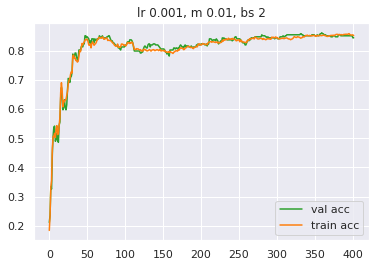

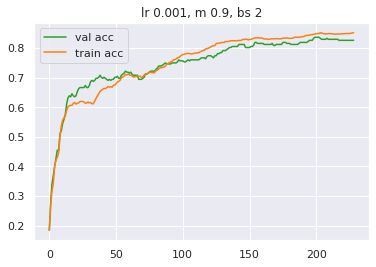

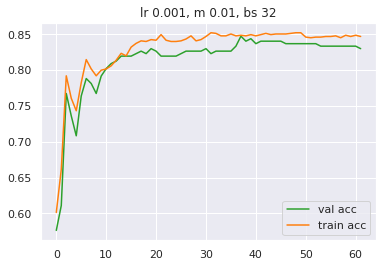

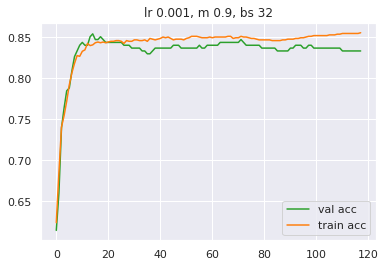

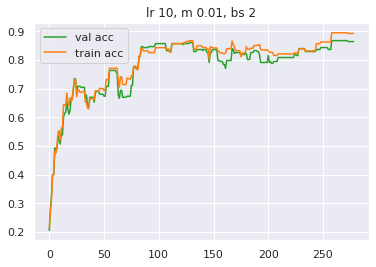

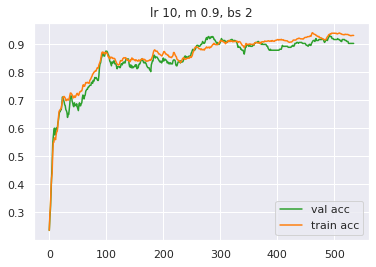

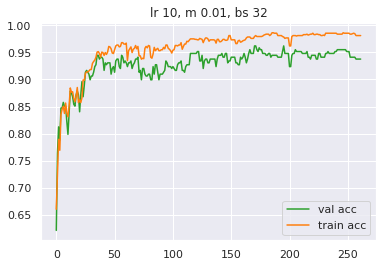

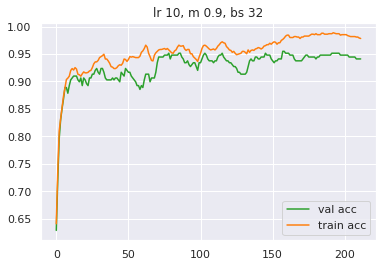

In [ ]:
# Digits Hyperparameter search
lr_list = [0.001, 10]
bs_list = [2, 32]
m_list = [0.01, 0.9]

# train, val split
index_folds = np.array_split(np.random.permutation(np.arange(X_trn_digits.shape[0])), 5)
val_fold = 0
X_trn = np.delete(X_trn_digits, index_folds[val_fold], axis=0)
X_val = X_trn_digits[index_folds[val_fold]]
y_trn = np.delete(y_trn_digits, index_folds[val_fold], axis=0)
y_val = y_trn_digits[index_folds[val_fold]]

for i, lr in tqdm(enumerate(lr_list)):
    for j, bs in tqdm(enumerate(bs_list)):
        for k, m in tqdm(enumerate(m_list)):
            scaler = sklearn.preprocessing.StandardScaler().fit(X_trn)
            X_trn = scaler.transform(X_trn)
            X_val = scaler.transform(X_val)

            # fit model
            optimizer = MiniBatchGradientMomentum(learning_rate=lr, batch_size=bs, momentum=m, verbose=False)
            trn_hist, val_hist = model.fit(X_trn, y_trn, X_val, y_val, optimizer)
            plt.figure()
            plt.title(f'Digits: lr {lr}, m {m}, bs {bs}')
            plt.plot(np.arange(len(val_hist)), val_hist, 'tab:green', label='val acc')
            plt.plot(np.arange(len(trn_hist)), trn_hist, 'tab:orange', label='train acc')
            plt.legend()

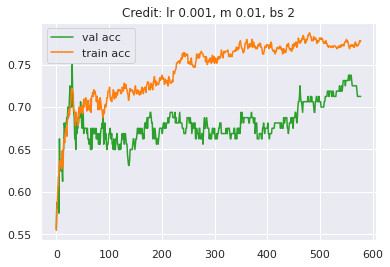

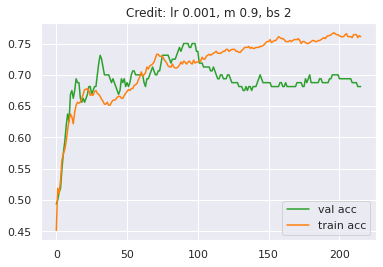

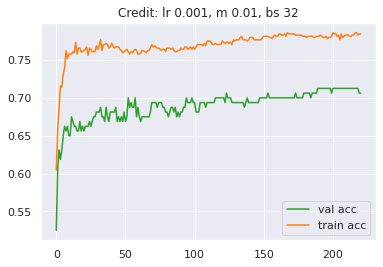

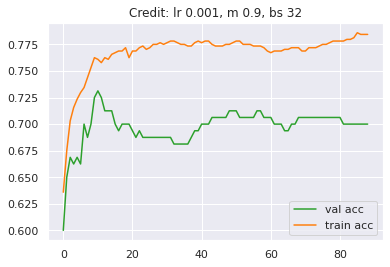

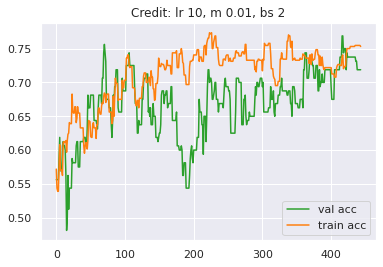

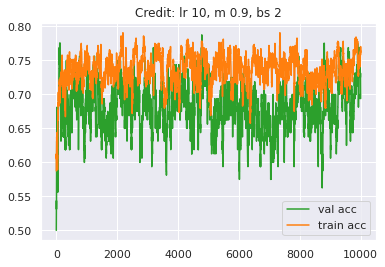

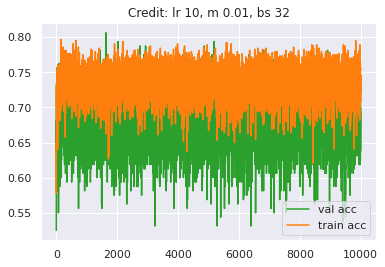

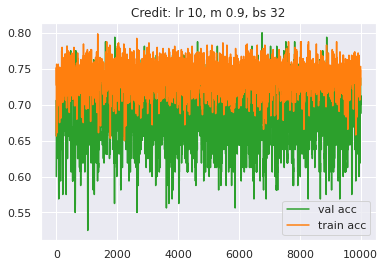

In [ ]:
# Credit Hyperparameter search
lr_list = [0.001, 10]
bs_list = [2, 32]
m_list = [0.01, 0.9]

# train, val split
index_folds = np.array_split(np.random.permutation(np.arange(X_trn_credit.shape[0])), 5)
val_fold = 0
X_trn = np.delete(X_trn_credit, index_folds[val_fold], axis=0)
X_val = X_trn_credit[index_folds[val_fold]]
y_trn = np.delete(y_trn_credit, index_folds[val_fold], axis=0)
y_val = y_trn_credit[index_folds[val_fold]]

for i, lr in tqdm(enumerate(lr_list)):
    for j, bs in tqdm(enumerate(bs_list)):
        for k, m in tqdm(enumerate(m_list)):
            scaler = sklearn.preprocessing.StandardScaler().fit(X_trn)
            X_trn = scaler.transform(X_trn)
            X_val = scaler.transform(X_val)

            # fit model
            optimizer = MiniBatchGradientMomentum(learning_rate=lr, batch_size=bs, momentum=m, verbose=False)
            trn_hist, val_hist = model.fit(X_trn, y_trn, X_val, y_val, optimizer)
            plt.figure()
            plt.title(f'Credit: lr {lr}, m {m}, bs {bs}')
            plt.plot(np.arange(len(val_hist)), val_hist, 'tab:green', label='val acc')
            plt.plot(np.arange(len(trn_hist)), trn_hist, 'tab:orange', label='train acc')
            plt.legend()

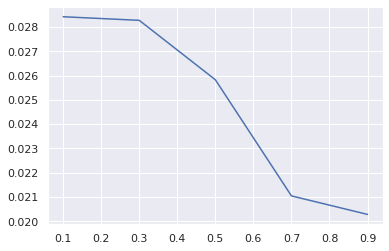

In [ ]:
# effect of hyperparameter on time

plt.plot(x, n[:,5])

(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)


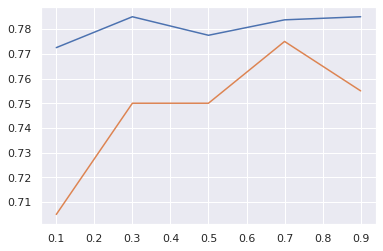

In [ ]:
# n is the data for the last fold
# we are going to analyze the effect of each hyper parameter on both accuracies
# by fixing two parameter and changing one

lr = [0.1]
bs = [32]
m = [0.1,0.3,0.5,0.7,0.9]

s, n = CrossVal(SoftmaxRegression(), 5, X_credit, y_credit, lr, bs, m)
x = m
plt.plot(x, n[:,3])
plt.plot(x, n[:,4])

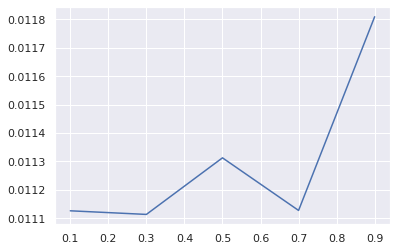

In [ ]:
# effect of hyperparameter on time

plt.plot(x, n[:,5])

(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)


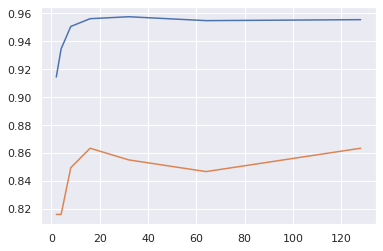

In [ ]:
# n is the data for the last fold
# we are going to analyze the effect of each hyper parameter on both accuracies
# by fixing two parameter and changing one

lr = [0.1]
bs = [2,4,8,16,32,64,128]
m = [0.9]

s, n = CrossVal(SoftmaxRegression(), 5, X_digits, y_digits, lr, bs, m)
x = bs
plt.plot(x, n[:,3])
plt.plot(x, n[:,4])


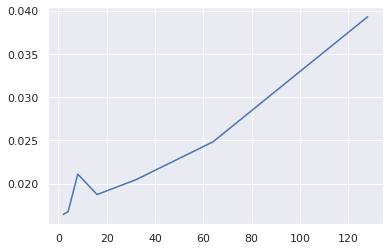

In [ ]:
# effect of hyperparameter on time

plt.plot(x, n[:,5])

(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)


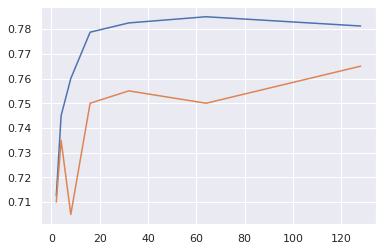

In [ ]:
# n is the data for the last fold, 
# s has the best hyper parameter with taining and validaion accuracies and time
# we are going to analyze the effect of each hyper parameter on both accuracies
# by fixing two parameter and changing one

lr = [0.1]
bs = [2,4,8,16,32,64,128]
m = [0.9]

s, n = CrossVal(SoftmaxRegression(), 5, X_credit, y_credit, lr, bs, m)
x = bs
plt.plot(x, n[:,3])
plt.plot(x, n[:,4])


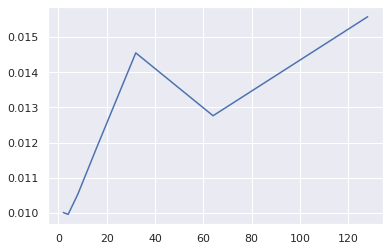

In [ ]:
# effect of hyperparameter on time

plt.plot(x, n[:,5])

(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)


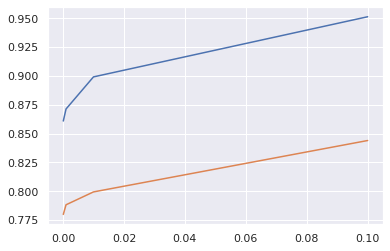

In [ ]:
# n is the data for the last fold
# we are going to analyze the effect of each hyper parameter on both accuracies
# by fixing two parameter and changing one

lr = [0.1,0.01,0.001,0.0001]
bs = [32]
m = [0.9]

s, n = CrossVal(SoftmaxRegression(), 5, X_digits, y_digits, lr, bs, m)
x = lr
plt.plot(x, n[:,3])
plt.plot(x, n[:,4])


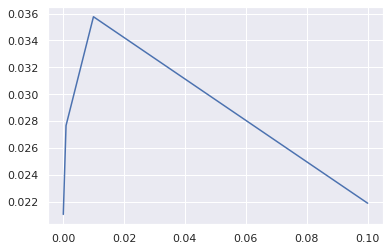

In [ ]:
# effect of hyperparameter on time

plt.plot(x, n[:,5])

(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)


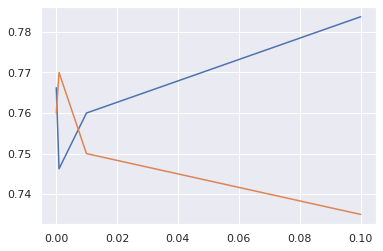

In [ ]:
# n is the data for the last fold
# we are going to analyze the affect of each hyper parameter on both accuracies
# by fixing two parameter and changing one

lr = [0.1,0.01,0.001,0.0001]
bs = [32]
m = [0.9]

s, n = CrossVal(SoftmaxRegression(), 5, X_credit, y_credit, lr, bs, m)
x = lr
plt.plot(x, n[:,3])
plt.plot(x, n[:,4])


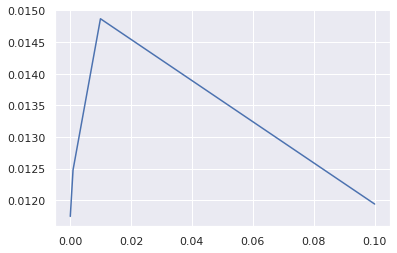

In [ ]:
# effect of hyperparameter on time

plt.plot(x, n[:,5])

In [ ]:
def CrossValL(model, cv_size, X, y):
  i = 0
  c = np.zeros((cv_size,3))

  while i < cv_size:
    # train, test split
    X_tst = X[i*int(round(1/cv_size*len(X))):(i+1)*int(round(1/cv_size*len(X))),:]
    X_trn = np.delete(X, list(range(i*int(round(1/cv_size*len(X))),(i+1)*int(round(1/cv_size*len(X))))), 0)
    y_tst = y[i*int(round(1/cv_size*len(y))):(i+1)*int(round(1/cv_size*len(y)))]
    y_trn = np.delete(y, list(range(i*int(round(1/cv_size*len(y))),(i+1)*int(round(1/cv_size*len(y))))), 0)
    # preprocess scales
    scaler = sklearn.preprocessing.StandardScaler().fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)
    #using DecisionTreeClassifier
    start = timeit.default_timer()
    model.fit(X_trn,y_trn)
    stop = timeit.default_timer()
    time = stop - start
    trn_acc = sklearn.metrics.accuracy_score(y_trn, model.predict(X_trn))
    val_acc = sklearn.metrics.accuracy_score(y_tst, model.predict(X_tst))
    c[i] = [trn_acc, val_acc, time]
    i+=1
  
  return c

In [ ]:
# obtaining accuracies and time for Digits Data set

lr = [0.1,0.01,0.001]
bs = [8,16,32]
m = [0.1,0.5,0.9]

s, n = CrossVal(SoftmaxRegression(), 5, X_digits, y_digits, lr, bs, m)
l = CrossValL(DecisionTreeClassifier(), 5, X_digits, y_digits)
trn_acc = [l[:,0], s[:,3]] 
val_acc = [l[:,1], s[:,4]] 
time = [l[:,2], s[:,5]]

(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(65, 10)
(

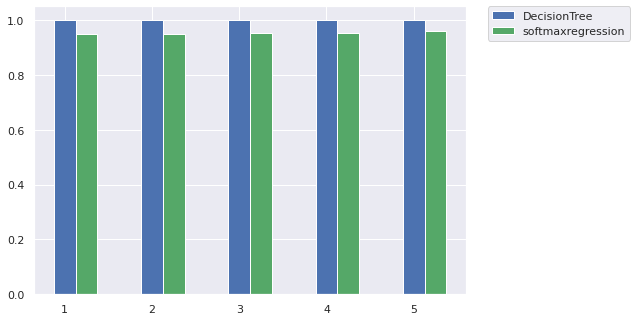

In [ ]:
# comparison of training accuracy

data = trn_acc
X = np.arange(5)+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
ax.legend(labels=['DecisionTree', 'softmaxregression'],bbox_to_anchor=(1.05, 1),loc='upper left',borderaxespad=0.)


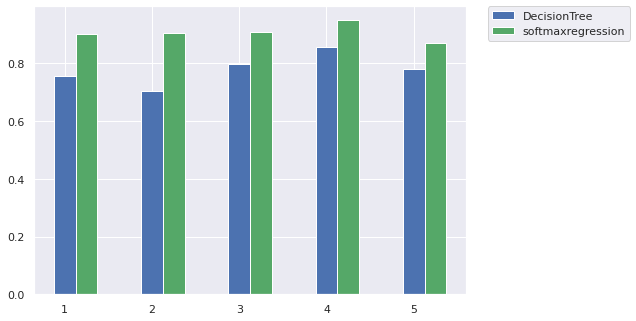

In [ ]:
#comparison of validation accuracy

data = val_acc
X = np.arange(5)+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
ax.legend(labels=['DecisionTree', 'softmaxregression'],bbox_to_anchor=(1.05, 1),loc='upper left',borderaxespad=0.)

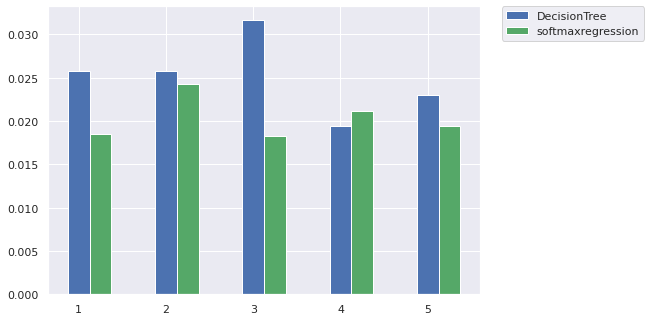

In [ ]:
# time

data = time
X = np.arange(5)+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
ax.legend(labels=['DecisionTree', 'softmaxregression'],bbox_to_anchor=(1.05, 1),loc='upper left',borderaxespad=0.)

In [ ]:
# obtaining accuracies and time for Credit Data set

lr = [0.1,0.01,0.001]
bs = [8,16,32]
m = [0.1,0.5,0.9]

s, n = CrossVal(SoftmaxRegression(), 5, X_credit, y_credit, lr, bs, m)
l = CrossValL(DecisionTreeClassifier(), 5, X_credit, y_credit)
trn_acc = [l[:,0], s[:,3]] 
val_acc = [l[:,1], s[:,4]] 
time = [l[:,2], s[:,5]]

(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)
(62, 2)


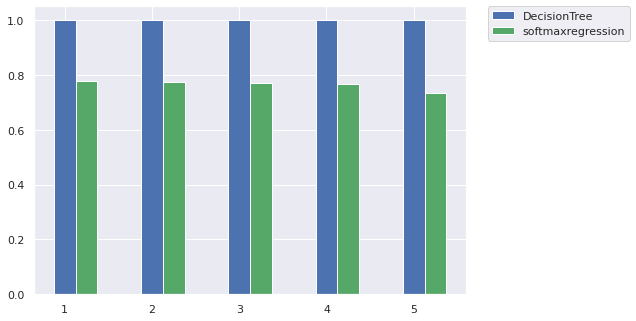

In [ ]:
# comparison of training accuracy

data = trn_acc
X = np.arange(5)+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
ax.legend(labels=['DecisionTree', 'softmaxregression'],bbox_to_anchor=(1.05, 1),loc='upper left',borderaxespad=0.)


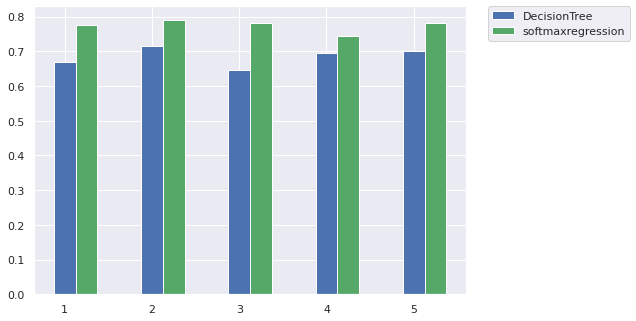

In [ ]:
#comparison of validation accuracy

data = val_acc
X = np.arange(5)+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
ax.legend(labels=['DecisionTree', 'softmaxregression'],bbox_to_anchor=(1.05, 1),loc='upper left',borderaxespad=0.)

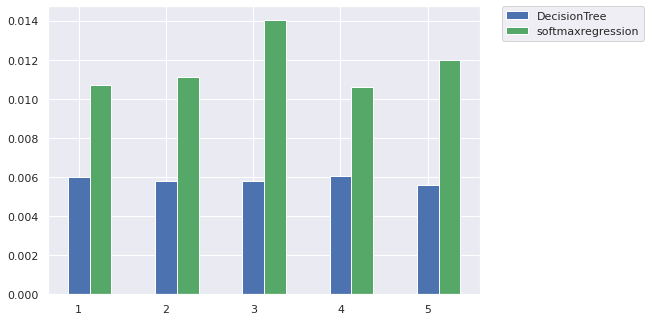

In [ ]:
# time

data = time
X = np.arange(5)+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
ax.legend(labels=['DecisionTree', 'softmaxregression'],bbox_to_anchor=(1.05, 1),loc='upper left',borderaxespad=0.)

In [ ]:

# softmax class is refactored a bit, predict method moved to optimizer class
# validation sets given as parameters to calculate accuracy for each iteration
class SoftmaxRegression:
    def __init__(self, add_bias=True, reg=0):
        self.add_bias = add_bias
        self.reg = reg

    def fit(self, x, y, X_val, y_val, optimizer, limit):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N,D = x.shape
        C = len(np.unique(y))

        def gradient(x, y, w):                          # define the gradient function
            N = x.shape[0]

            # Softmax calculation
            scores = x.dot(w)
            scores -= np.max(scores, axis=1, keepdims=True)
            exp_scores = np.exp(scores)
            softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # dw calculation
            indices = np.arange(N)
            softmax_editted = softmax
            softmax_editted[indices, y] -= 1
            dw = np.dot(x.T, softmax_editted)
            dw /= N
            dw += self.reg * 2 * w
            return dw

        w0 = np.zeros((D, C))                                                # initialize the weights to 0
        self.w = optimizer.run(gradient, x, y, w0, X_val, y_val, limit)      # run the optimizer to get the optimal weights      
        return self


class MiniBatchGradientMomentum:
    def __init__(self, add_bias=True, learning_rate=.001, batch_size=16, momentum=0.9, max_iters=25000, epsilon=1e-8, record_history=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.momentum = momentum
        self.batch_size = batch_size
        if record_history:
            self.w_history = []                

    def run(self, gradient_fn, x, y, w, X_val, y_val, limit):
        grad = np.inf
        t = 1
        delta_w = 0
        val_accs = []

        # need at least (limit) iterations to look at
        # check validation accuracy values have not decreased for last (limit) iterations
        # add a max iterations check so we don't loop forever in case 2 conditions above fail to stop loop
        while t < self.max_iters and (t < limit or not self.decreasing(val_accs, t, limit, self.epsilon)):
            batch_inds = np.random.choice(x.shape[0], self.batch_size)
            grad = gradient_fn(x[batch_inds], y[batch_inds], w)
            delta_w = self.momentum * delta_w + (1 - self.momentum) * grad              
            w = w - self.learning_rate * delta_w       
            if self.record_history:
                self.w_history.append(w)
            val_acc = sklearn.metrics.accuracy_score(y_val, self.predict(X_val, w))
            val_accs.append(val_acc)
            t += 1
      
        # it is possible the last (limit) iterations happened at the exact so we need an extra check
        # for non decreasing values
        if t == self.max_iters and not self.decreasing(val_accs, t-1, limit, self.epsilon):
            print(f'best validation accuracy ({val_acc}) overshoot to the maximum {t} iterations based on last {limit} values')
        else:
            print(f'best validation accuracy ({val_acc}) found after {t} iterations based on last {limit} values')

        # since we stored accuracy values at each iteration we can compare with the real best value
        print(f'true best result is {max(val_accs)} which happened after {val_accs.index(max(val_accs))} iterations')
        return w
    
    def decreasing(self, values, t, limit, epsilon):
        return all(0<=x-y<=epsilon for x, y in zip(values[t-limit:t], values[t-limit+1:t+1]))

    def predict(self, x, w):
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])
        yh = x@w
        y_pred = np.argmax(yh, axis=1)
        return y_pred

In [ ]:
model = SoftmaxRegression()

optimizer = MiniBatchGradientMomentum(learning_rate=.005, max_iters=10000, batch_size=16, record_history=True)
model.fit(X_trn_credit, y_trn_credit, X_val_credit, y_val_credit, optimizer, 200)

optimizer = MiniBatchGradientMomentum(learning_rate=.005, max_iters=20000, batch_size=16, record_history=True)
model.fit(X_trn_digits, y_trn_digits, X_val_digits, y_val_digits, optimizer, 4000)


best validation accuracy (0.755) overshoot to the maximum 10000 iterations based on last 200 values
true best result is 0.785 which happened after 288 iterations
best validation accuracy (0.9611111111111111) overshoot to the maximum 20000 iterations based on last 4000 values
true best result is 0.9611111111111111 which happened after 10762 iterations
